In [1]:
# !wget https://fashion-simulation.s3.amazonaws.com/assignment/nerf_datasets/testing_data.pkl
# !wget https://fashion-simulation.s3.amazonaws.com/assignment/nerf_datasets/training_data.pkl

In [2]:
import torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [3]:
# Hyperparams
class Arguments:
    def __init__(self):
        self.device = 'mps'
        self.hn=0 
        self.hf=0.5 
        self.nb_bins=192
        self.embedding_dim_pos = 6
        self.embedding_dim_direction = 4
        self.hidden_dim = 128

args = Arguments()

# Piece-wise Constant Transmittance Equation
<div>
<img src='../assets/transmittance.png'>
</div>

Here, $\delta_k$ is constant for as the ray are uniformly breakdown.

$\sigma_k$ is constant for the piece-wise segment.

$\alpha_k = 1 - exp(-\sigma_k \delta_k)$

$exp(-\sigma_k \delta_k) = 1 - \alpha_k$

$T_n = exp(\sum_{k=1}^{n-1} -\sigma_k \delta_k) = \prod_{k=1}^{n-1} exp( -\sigma_k \delta_k) = \prod_{k=1}^{n-1} (1 - \alpha_k)$

In [4]:
def compute_accumulated_transmittance(alphas):
    accumulated_transmittance = torch.cumprod(1 - alphas, dim=1)
    ones = torch.ones((accumulated_transmittance.shape[0], 1), device=alphas.device) 
    return torch.cat((ones, accumulated_transmittance[:, :-1]), dim=-1) # Making first element of each series as 1 and leaving out the last element of cumprod

# NeRF Architecture
<div>
<img src='../assets/NeRFModel.png'>
</div>

In [5]:
class NeRFModel(nn.Module):
    def __init__(self, embedding_dim_pos=6, embedding_dim_direction=4, hidden_dim=256):
        super(NeRFModel, self).__init__()

        input_dim_block1 = embedding_dim_pos * 6 + 3
        layer_activation = nn.ReLU()

        self.block1 = nn.Sequential(nn.Linear(input_dim_block1, hidden_dim),
                                    layer_activation,
                                    nn.Linear(hidden_dim, hidden_dim),
                                    layer_activation,
                                    nn.Linear(hidden_dim, hidden_dim),
                                    layer_activation,
                                    nn.Linear(hidden_dim, hidden_dim),
                                    layer_activation)

        # density estimation
        input_dim_block2 = embedding_dim_pos * 6 + hidden_dim + 3

        self.block2 = nn.Sequential(nn.Linear(input_dim_block2, hidden_dim),
                                    layer_activation,
                                    nn.Linear(hidden_dim, hidden_dim),
                                    layer_activation,
                                    nn.Linear(hidden_dim, hidden_dim),
                                    layer_activation,
                                    nn.Linear(hidden_dim, hidden_dim + 1))

        # color estimation
        self.block3 = nn.Sequential(nn.Linear(embedding_dim_direction * 6 + hidden_dim + 3, hidden_dim // 2), nn.ReLU(), )
        
        self.block4 = nn.Sequential(nn.Linear(hidden_dim // 2, 3), nn.Sigmoid(), )

        self.embedding_dim_pos = embedding_dim_pos
        self.embedding_dim_direction = embedding_dim_direction
        self.relu = nn.ReLU()

    @staticmethod
    def positional_encoding(x, L):
        out = [x]
        for j in range(L):
            out.append(torch.sin(2 ** j * x))
            out.append(torch.cos(2 ** j * x))
        return torch.cat(out, dim=1)

    def forward(self, o, d):
        emb_x = self.positional_encoding(o, self.embedding_dim_pos) # emb_x: [batch_size, embedding_dim_pos * 6 + 3]
        emb_d = self.positional_encoding(d, self.embedding_dim_direction) # emb_d: [batch_size, embedding_dim_direction * 6 + 3]
        h = self.block1(emb_x) # h: [batch_size, hidden_dim]

        tmp = self.block2(torch.cat((h, emb_x), dim=1)) # tmp: [batch_size, hidden_dim + 1]

        h, sigma = tmp[:, :-1], self.relu(tmp[:, -1]) # h: [batch_size, hidden_dim], sigma: [batch_size]

        h = self.block3(torch.cat((h, emb_d), dim=1)) # h: [batch_size, hidden_dim // 2]

        c = self.block4(h) # c: [batch_size, 3]
        return c, sigma

# Ray Equation
$$r = o + td$$

<div>
<img src='../assets/renderingEquation.png'>
</div>

In [6]:
def render_rays(nerf_model, ray_origins, ray_directions, hn=0, hf=0.5, nb_bins=192):

    # ray_origins : torch.Size([8192, 3]) || ray_directions : torch.Size([8192, 3])

    device = ray_origins.device
    t = torch.linspace(hn, hf, nb_bins).to(device) # [32]

    # Compute the 3D points along each ray
    t = t.unsqueeze(dim=0).unsqueeze(2) # [1, 32, 1]
    r = ray_origins.unsqueeze(1) + t * ray_directions.unsqueeze(1)  # [batch_size, nb_bins, 3]

    # Expand the ray_directions tensor to match the shape of x
    ray_directions = ray_directions.expand(nb_bins, ray_directions.shape[0], 3).transpose(0, 1) # [batch_size, nb_bins, 3]


    colors, sigma = nerf_model(r.reshape(-1, 3), ray_directions.reshape(-1, 3)) # x : [batch_size * nb_bins, 3], ray_directions : [batch_size * nb_bins, 3]  
    colors = colors.reshape(r.shape)  # [batch_size, nb_bins, 3]
    sigma = sigma.reshape(r.shape[:-1])  # [batch_size, nb_bins]

    alpha = 1 - torch.exp(-sigma*(hf-hn)/nb_bins)  # [batch_size, nb_bins]

    weights = compute_accumulated_transmittance(alpha) * alpha
    
    # Compute the pixel values as a weighted sum of colors along each ray
    c = (weights.unsqueeze(2) * colors).sum(dim=1)
    
    weight_sum = weights.sum(-1)  # Regularization for white background
    
    return c + 1 - weight_sum.unsqueeze(-1)

In [7]:
@torch.no_grad()
def test(hn, hf, dataset, chunk_size=10, img_index=0, nb_bins=192, H=400, W=400):
    """
    Args:
        hn: near plane distance
        hf: far plane distance
        dataset: dataset to render
        chunk_size (int, optional): chunk size for memory efficiency. Defaults to 10.
        img_index (int, optional): image index to render. Defaults to 0.
        nb_bins (int, optional): number of bins for density estimation. Defaults to 192.
        H (int, optional): image height. Defaults to 400.
        W (int, optional): image width. Defaults to 400.

    Returns:
        None: None
    """
    ray_origins = dataset[img_index * H * W: (img_index + 1) * H * W, :3]
    ray_directions = dataset[img_index * H * W: (img_index + 1) * H * W, 3:6]

    data = []   # list of regenerated pixel values
    for i in range(int(np.ceil(H / chunk_size))):   # iterate over chunks
        # Get chunk of rays
        ray_origins_ = ray_origins[W*chunk_size*i:W*chunk_size*(i+1)].to(device)
        ray_directions_ = ray_directions[W*chunk_size*i:W*chunk_size*(i+1)].to(device)

        regenerated_px_values = render_rays(model, ray_origins_, ray_directions_, hn=hn, hf=hf, nb_bins=nb_bins)
        data.append(regenerated_px_values)
    img = torch.cat(data).data.cpu().numpy().reshape(H, W, 3)

    plt.figure()
    plt.imshow(img)

In [8]:
def train(nerf_model, optimizer, scheduler, data_loader, testing_dataset, device='cpu', hn=0, hf=1, nb_epochs=int(1e5),
          nb_bins=192, H=400, W=400):
    training_loss = []
    for _ in tqdm(range(nb_epochs)):
        for batch in data_loader:
            ray_origins = batch[:, :3].to(device)
            ray_directions = batch[:, 3:6].to(device)
            ground_truth_px_values = batch[:, 6:].to(device)
            regenerated_px_values = render_rays(nerf_model, ray_origins, ray_directions, hn=hn, hf=hf, nb_bins=nb_bins)
            loss = ((ground_truth_px_values - regenerated_px_values) ** 2).sum()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            training_loss.append(loss.item())
            print(f"Loss : {loss}")
        scheduler.step()

        # for img_index in range(100):
        test(hn, hf, testing_dataset, img_index=0, nb_bins=nb_bins, H=H, W=W)
    return training_loss

  0%|          | 0/1 [00:00<?, ?it/s]

Loss : 2512.7177734375
Loss : 5194.98828125
Loss : 2696.12158203125
Loss : 2254.716064453125
Loss : 2204.958984375
Loss : 2213.71533203125
Loss : 2238.021728515625
Loss : 2248.318603515625
Loss : 2184.906982421875
Loss : 2168.927001953125
Loss : 2243.16748046875
Loss : 2169.42138671875
Loss : 2161.904296875
Loss : 2097.83984375
Loss : 2102.62939453125
Loss : 2050.658447265625
Loss : 1945.955078125
Loss : 1935.965576171875
Loss : 1874.9072265625
Loss : 1852.2281494140625
Loss : 1730.041748046875
Loss : 1592.8797607421875
Loss : 1489.24658203125
Loss : 1306.9599609375
Loss : 1178.581298828125
Loss : 1064.763427734375
Loss : 1049.0928955078125
Loss : 1154.7103271484375
Loss : 879.5115356445312
Loss : 1075.794677734375
Loss : 853.7487182617188
Loss : 930.5036010742188
Loss : 823.4303588867188
Loss : 783.0592651367188
Loss : 843.4924926757812
Loss : 719.2418823242188
Loss : 738.359130859375
Loss : 763.9713134765625
Loss : 673.611572265625
Loss : 700.5177612304688
Loss : 708.08349609375
Loss

100%|██████████| 1/1 [01:13<00:00, 73.69s/it]


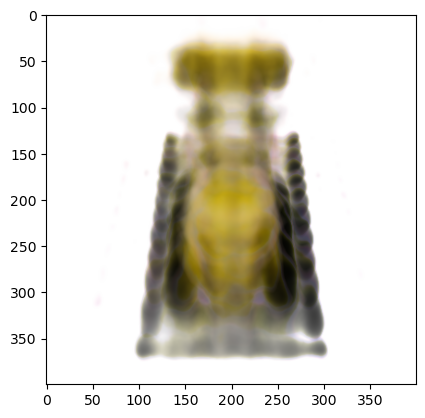

In [9]:
device = 'mps'
training_dataset = torch.from_numpy(np.load('training_data.pkl', allow_pickle=True))
downscaled_data = training_dataset.reshape([100, 400, 400, 9])[..., ::4, ::4, 0:9].flatten(end_dim=-2)
testing_dataset = torch.from_numpy(np.load('testing_data.pkl', allow_pickle=True))
model = NeRFModel(hidden_dim=256).to(device)
model_optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)
scheduler = torch.optim.lr_scheduler.MultiStepLR(model_optimizer, milestones=[2, 4, 8], gamma=0.5)
data_loader = DataLoader(downscaled_data, batch_size=8*1024, shuffle=True)
print(f" ")
loss = train(model, model_optimizer, scheduler, data_loader, testing_dataset, nb_epochs=1, device=device, hn=2, hf=6, nb_bins=32, H=400, W=400)